**0. Set environment**

In [ ]:
#===============================
# 0.0 set google drive
#===============================
from google.colab import drive
drive.mount('/content/drive')       

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#===================================
# 0.1 additional packages to install if in google colab
#===================================
!pip install efficientnet_pytorch==0.7.0
!pip install --upgrade matplotlib

In [ ]:
#===================================
# 0.2 import helper functions
#===================================
exec(open('drive/path/to/external.py').read())
exec(open('drive/path/to/models.py').read())
exec(open('drive/path/to/utils.py').read())

print('all done')

all done


**1. Data Preparation**

In [ ]:
#===================================
# 1.0 load data
#===================================
'''
1. training_data: 1. list of tuples: ((img_size, img_size, 3), label). 2. or (n, img_size, img_size, 3).
2. labeling_data: (n, img_size, img_size, 3) average images for linear evaluation.
3. mask (img_size, img_size): on-tissue: 0, off-tissue: 1.
'''
## load data
training_data = np.load('drive/path/to/training_data.npy', allow_pickle=True)
labeling_data = np.load('drive/path/to/labeling_data.npy', allow_pickle=True)

## load mass list
MassList = np.load('drive/path/to/mass_list.npy', allow_pickle=True)

## load mask
mask = np.load('drive/path/to/mask.npy', allow_pickle=True)

## process data for output
# parse training data
imgs = []
for i in range(training_data.shape[0]):
    img = training_data[i][0]
    imgs.append(img)
imgs = np.array(imgs)

# process mass list
mzs = []
for i in range(MassList.shape[0]):
    mz = MassList[i][0] + '  ' + MassList[i][1]
    mzs.append(mz)
mzs = np.array(mzs)

print(training_data.shape)

(367, 2)


In [ ]:
#===================================
# 1.1 organize npy data into PIL to work with DatasetWrapper
#===================================
'''
1. randomize data, 2. get PIL set and labels, 3. get dataloader for evaluation 
'''
# 1. randomize the source training data
training_data, imgs, mzs = shuffle(training_data, imgs, mzs)

# 2. PIL set and labels
training_PIL_set, training_labels = get_PIL_set(training_data)
labeling_PIL_set, labeling_labels = get_PIL_set(labeling_data)

# 3. get dataloader
dataset = get_torch_dataset(training_data)
dataloader = DataLoader(dataset, batch_size=128)

print(len(training_PIL_set), len(labeling_PIL_set), len(dataset))

367 13 367


**2. Data augmentation**

In [ ]:
#==========================================
# 2.0 wrap up image augmentation functions
#==========================================
## priors
'''
several img_aug functions depend on the image size.
'''
#mask
target_size = (96, 96)
blur_kernel_size = 9
translation_pad_size = 3

## import basic functions
exec(open('drive/path/to/augmentations.py').read())

## wrap up img aug combos
trans_weak = transforms.Compose(trans_blur2 + trans_color1 + trans_noise2_mask)
trans_medium = transforms.Compose(trans_blur2 + trans_color2 + trans_noise2)
trans_strong = transforms.Compose(trans_blur3 + trans_color2 + trans_noise3_mask)

print('all done')

all done


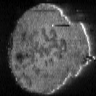

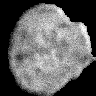

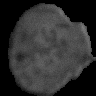

In [ ]:
#===================================
# 2.1 test data augmentation on PIL set
#===================================
# randomly select idx
idx = 196

# data wrapper
ds = DatasetWrapper_SimCLR(training_PIL_set, trans_strong)

# original img
display(training_PIL_set[idx])
# augmented img 1 in pairs
display(tvf.to_pil_image(ds.raw(idx)[0]))
# augmented img 2 in pairs
display(tvf.to_pil_image(ds.raw(idx)[1]))

**3. Pretrained CNN Model**

*   EfficientNet-B0

In [ ]:
#===================================
# 3.1 Run data through pretrained EfficientNet-B0
#===================================
## 3.1.0 run EfficientNet model without learning
# get model
model_effnet = effnet_model_fc0()
# run thru model for embeddings
effnet_feat = run_thru_NN(model_effnet, dataloader, 'others')
effnet_feat = effnet_feat.cpu().numpy()


## 3.1.1 tsne visualization 
tsne = TSNE()
tsne_effnet = tsne.fit_transform(effnet_feat)
plot_2d_scatter(tsne_effnet, training_labels, 'EfficientNet') 

Loaded pretrained weights for efficientnet-b0


In [ ]:
#===================================
# 3.2 SC (spectral clustering)
#===================================

## 3.2.0 SC clustering
hparams_SC = Namespace(
    n_neighbors = 10,
    n_clusters = 20, 
)

# clustering
SC_cluster = SpectralClustering(n_clusters = hparams_SC.n_clusters, 
                             n_neighbors = hparams_SC.n_neighbors, 
                             affinity = 'nearest_neighbors', 
                             assign_labels='discretize')
initial_labels = SC_cluster.fit_predict(effnet_feat)

## 3.2.1 visualization
# check accuracy if we have benchmark groundtruth
SC_acc, _ = get_Acc(initial_labels, training_labels)
print('Accuracy of SimCLR + SC: {}'.format(SC_acc))

Accuracy of SimCLR + SC: 0.7223


**4. Self-supervised clustering**
*    SimCLR
*    SC (spectral clustering) + linear classifier initialization
*    FineTune 

**4.1 SimCLR**

In [ ]:
#===================================
# 4.1 SimCLR
#===================================

# 4.1.0 make output folder for all 3 steps
#===================================
# time_stamp
moment = datetime.now(tz) 
moment = str(moment.date()) + '_' + str(moment.hour) + '-' + str(moment.minute)
# root_folder dir
output_folder = 'Self-supervised-clustering__' + moment
# make folder for output
os.mkdir(output_folder)

# 4.1.1 CLR training
#===================================
# hparams for training module
hparams_CLR = Namespace(
    data = training_PIL_set,
    trans = trans_medium,
    lr = 1e-3,
    epochs = 50,
    batch_size = 183,
    train_size = 367                     # the last batch is dropped.
)

model_CLR, _ = fit_CLR(hparams_CLR, output_folder, verbose=False)

# 4.1.2 CLR embedding visualization
#===================================
# run thru model for embeddings
CLR_feat = run_thru_NN(model_CLR, dataloader, 'emb')
CLR_feat = CLR_feat.cpu().numpy()

# tsne visualizaiton 
tsne = TSNE()       
tsne_CLR = tsne.fit_transform(CLR_feat)
plot_2d_scatter(tsne_CLR, training_labels, 'SimCLR') 

Loaded pretrained weights for efficientnet-b0


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
#===================================
# 4.1b SimCLR (from checkpoint)
#===================================

# 4.1b.1 load model
#===================================
model_CLR = CLR()
model_CLR.load_state_dict(torch.load('model_CLR.ckpt'))

# 4.1b.2 CLR embedding visualization
#===================================
# run thru model for embeddings
CLR_feat = run_thru_NN(model_CLR, dataloader, 'emb')
CLR_feat_norm = F.normalize(CLR_feat, dim=1).cpu().numpy()
CLR_feat = CLR_feat.cpu().numpy()

# # tsne visualizaiton 
tsne = TSNE()                     
tsne_CLR = tsne.fit_transform(CLR_feat)
plot_2d_scatter(tsne_CLR, training_labels, 'SimCLR') 

Loaded pretrained weights for efficientnet-b0


**4.2 SC + linear classifier initialization**

In [ ]:
#===================================
# 4.2 SC + meta label training
#===================================

# 4.2.0 SC
#===================================
hparams_SC = Namespace(
    n_neighbors = 10,
    n_clusters = 20, 
)

# clustering
SC_cluster = SpectralClustering(n_clusters = hparams_SC.n_clusters, 
                             n_neighbors = hparams_SC.n_neighbors, 
                             affinity = 'nearest_neighbors', 
                             assign_labels='discretize')
initial_labels = SC_cluster.fit_predict(CLR_feat)

# check accuracy if we have benchmark groundtruth
SC_acc, _ = get_Acc(initial_labels, training_labels)
print('Accuracy of SimCLR + SC: {}'.format(SC_acc))

# 4.2.1 CLR_CLS (frozen SimCLR trained CNN base + active classification layer)
#===================================
hparams_CLS = Namespace(
    data = training_PIL_set,             
    labels = initial_labels,
    n_classes = hparams_SC.n_clusters,
    freeze_base = True,
    embeddings_path = output_folder + '/model_CLR.ckpt',
    lr = 1e-3,                                             
    epochs = 20,
    batch_size = 183,                   
    train_size = 367,                                       # the last batch is dropped
    prob_thre = 0.4
)

model_CLS, _ = fit_CLS(hparams_CLS, output_folder, verbose=False)

# 4.2.1 CLR_CLS follow-up
#===================================
projections = run_thru_NN(model_CLS, dataloader, 'proj')
predictions = torch.argmax(projections, dim = 1)
predictions = predictions.cpu().numpy()
onehots = F.softmax(projections, dim = 1).cpu().numpy()
probs = np.max(onehots, axis=1)
CLS_prob_thre = np.quantile(probs, hparams_CLS.prob_thre)  # initially take 60% more confident samples for FineTune

# check accuracy if we have benchmark groundtruth
CLS_acc, _ = get_Acc(predictions, training_labels)
print('Accuracy of SimCLR + Linear classifier: {}'.format(SC_acc))

Accuracy of SimCLR + SC: 0.9203
Loaded pretrained weights for efficientnet-b0
During the training of current CLR_CLS model, the CNN base is frozen


  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy of SimCLR + Linear classifier: 0.9203


**4.3 FineTune**

In [ ]:
#===================================
# 4.3 FineTune
#===================================

# 4.3.0 FineTune
#===================================
hparams_FineTune = Namespace(
    # model
    n_classes = hparams_SC.n_clusters,
    freeze_base = False,
    model_CLR_path = output_folder + '/model_CLR.ckpt',
    model_CLS_path = output_folder + '/model_CLS.ckpt',

    # confidence based loss parameters
    threshold = CLS_prob_thre,
    apply_class_balancing = True,   

    # dataset
    data = training_PIL_set,
    trans1 = trans_weak,
    trans2 = trans_strong,
    
    # traning
    batch_size = 183,
    train_size = 367,
    lr = 1e-4,
    epochs = 150,
)

model_FineTune, _, _ = fit_FineTune(hparams_FineTune, output_folder, verbose = False)

# 4.3.1 output clustering results
#===================================
projections = run_thru_NN(model_FineTune, dataloader, 'proj')
predictions = torch.argmax(projections, dim = 1)
predictions = predictions.cpu().numpy()
onehots = F.softmax(projections, dim = 1).cpu().numpy()
probs = np.max(onehots, axis=1)

# check accuracy if has benchmark groundtruth
FineTune_acc, _ = get_Acc(predictions, training_labels)
print('Accuracy of SimCLR + SC + FineTune: {}'.format(FineTune_acc))

Loaded pretrained weights for efficientnet-b0


  0%|          | 0/150 [00:00<?, ?it/s]

Accuracy of SimCLR + SC + FineTune: 0.9456


In [ ]:
#===================================
# 4.3b FineTune (from checkpoint)
#===================================

# 4.3b.0 import model (step 2&3 use the same NN model: CLR_CLS)
#===================================
model_FineTune = CLR_CLS(20, True, 'model_CLR.ckpt')
model_FineTune.load_state_dict(torch.load('model_FineTune.ckpt'))

# 4.3b.1 output clustering results
#===================================
projections = run_thru_NN(model_FineTune, dataloader, 'proj')
predictions = torch.argmax(projections, dim = 1)
predictions = predictions.cpu().numpy()
onehots = F.softmax(projections, dim = 1).cpu().numpy()
probs = np.max(onehots, axis=1)

# check accuracy if has benchmark groundtruth
FineTune_acc, _ = get_Acc(predictions, training_labels)
print('Accuracy of SimCLR + SC + FineTune: {}'.format(FineTune_acc))

Loaded pretrained weights for efficientnet-b0
During the training of current CLR_CLS model, the CNN base is frozen
Accuracy of SimCLR + SC + FineTune: 0.9611


**5. Output results**

In [ ]:
output_montage_split(imgs, mzs, predictions, 'hot', 1.1, 1, SaveDir='Self-supervised clustering.png')

workong on the montage plotting:


  0%|          | 0/20 [00:00<?, ?it/s]

all done
